              ### Nexygen Carbon Emission Forecasting

#### Introduction

This project develops a forecasting framework to predict future Scope 1 and Scope 2 carbon emissions for Nexygen Energy using historical emissions, energy consumption, and asset-level operational data.

The model incorporates factors such as energy usage, fuel and electricity types, emission factors, asset characteristics, seasonal demand patterns, and operational status. It also considers strategic inputs including efficiency initiatives and renewable energy adoption.

The objective is to generate forward-looking emissions projections and scenario insights that support net-zero tracking, regulatory reporting, and data-driven sustainability decision-making.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
# read in the file
df = pd.read_csv('ESG_Data.csv', parse_dates= ['Date'])

In [3]:
df.head()

,Date,Year,Asset_ID,Asset_Type,Location,Operational_Status,Energy_Type,Consumption_Units,Emission_Type,Emissions_tCO2e,Target_Emissions_tCO2e,Reduction_Percentage_vs_BaseYear
0,2020-01-01,2020,A001,ServiceHub,England,Active,ELECTRICITY_KWH,2357.044,Scope 1,0.645377,15004.345,0.0
1,2020-01-01,2020,A001,ServiceHub,England,Active,ELECTRICITY_KWH,2357.044,Scope 2,0.530871,15004.345,0.0
2,2020-01-02,2020,A001,ServiceHub,England,Active,ELECTRICITY_KWH,2440.574,Scope 1,0.688000,15004.345,0.0
3,2020-01-02,2020,A001,ServiceHub,England,Active,ELECTRICITY_KWH,2440.574,Scope 2,0.572372,15004.345,0.0
4,2020-01-03,2020,A001,ServiceHub,England,Active,ELECTRICITY_KWH,2396.825,Scope 1,0.715998,15004.345,0.0


### Data Examination

In [4]:
# Basic informations
print(f'data_shape: {df.shape}')
print(f'data_shape: {df.info()}')
print(f'data_shape: {df['Date'].min()} to {df['Date'].max()}')

# check for duplicates
print(f'data_shape: {df.duplicated().sum()}')
print(f'data_shape: {df.duplicated(['Date', 'Asset_ID']).sum()}')


data_shape: (236736, 12)
<class 'pandas.DataFrame'>
RangeIndex: 236736 entries, 0 to 236735
Data columns (total 12 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   Date                              236736 non-null  datetime64[us]
 1   Year                              236736 non-null  int64         
 2   Asset_ID                          236736 non-null  str           
 3   Asset_Type                        236736 non-null  str           
 4   Location                          236736 non-null  str           
 5   Operational_Status                236736 non-null  str           
 6   Energy_Type                       236736 non-null  str           
 7   Consumption_Units                 236736 non-null  float64       
 8   Emission_Type                     236736 non-null  str           
 9   Emissions_tCO2e                   236736 non-null  float64       
 10  Target_Emissions_t

In [5]:
# checking for cardinality
for col in df.select_dtypes(include = 'str').columns.to_list():
    print(f'{col}: {df[col].nunique()} \n')

    

Asset_ID: 18 

Asset_Type: 5 

Location: 3 

Operational_Status: 1 

Energy_Type: 3 

Emission_Type: 2 



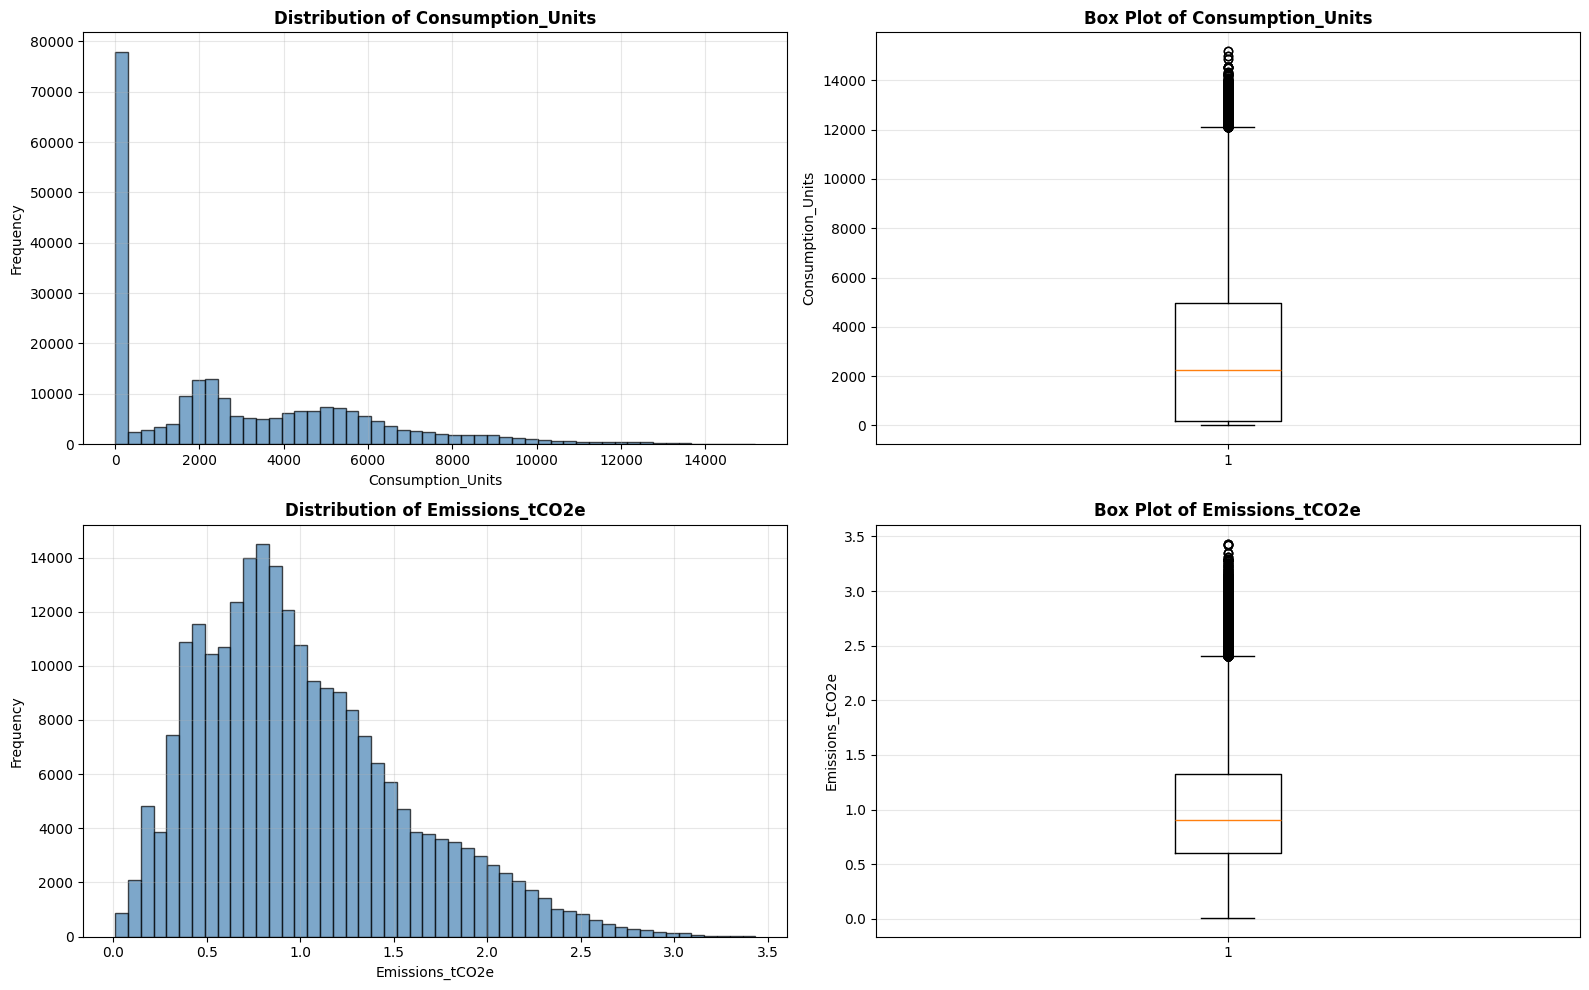

In [6]:
# Distribution of key numeric variables
numeric_cols = ['Consumption_Units', 'Emissions_tCO2e']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for idx, col in enumerate(numeric_cols):
    # Histogram
    axes[idx, 0].hist(df[col], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx, 0].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[idx, 0].set_xlabel(col)
    axes[idx, 0].set_ylabel('Frequency')
    axes[idx, 0].grid(True, alpha=0.3)

    # Box plot
    axes[idx, 1].boxplot(df[col], vert=True)
    axes[idx, 1].set_title(f'Box Plot of {col}', fontsize=12, fontweight='bold')
    axes[idx, 1].set_ylabel(col)
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Exploratory Data Analysis

<Axes: xlabel='Emission_Type'>

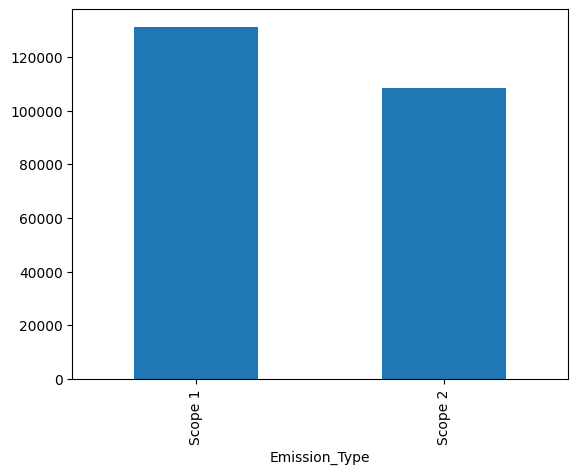

In [7]:
emission_scope_dist  = df.groupby('Emission_Type')['Emissions_tCO2e'].sum()

emission_scope_dist.plot(kind='bar')

## Time Series Analysis


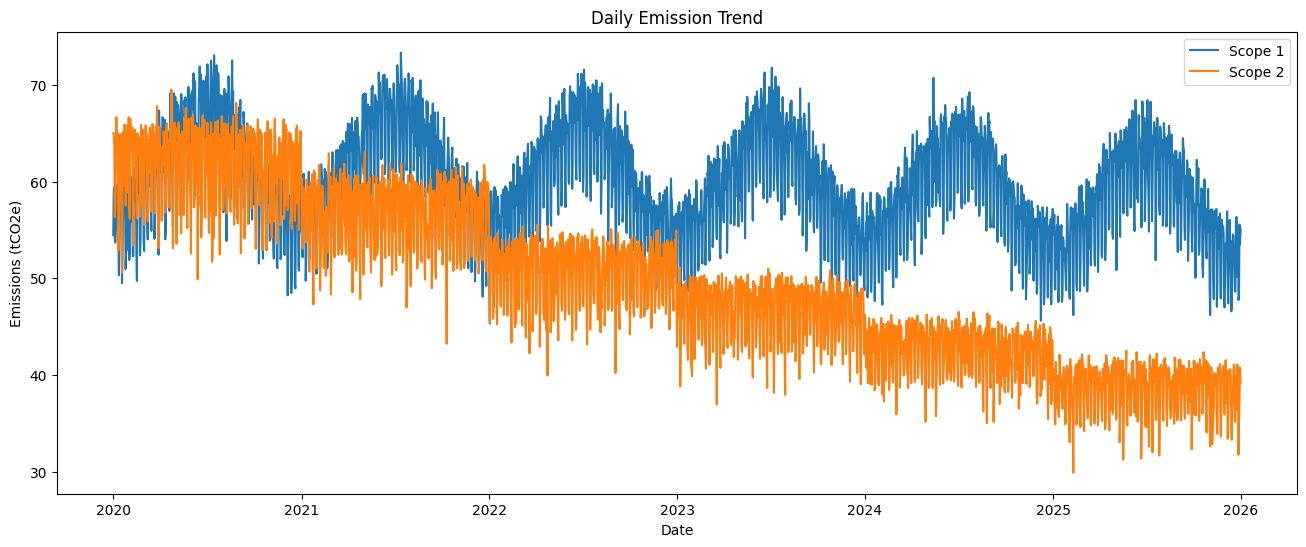

In [8]:
# Aggregate total emissions per day and per emission type (Scope 1 & Scope 2)
# This ensures that if multiple records exist for the same date,
# they are summed into a single daily total.
daily_emission = (
    df.groupby(['Date', 'Emission_Type'])['Emissions_tCO2e']
      .sum()
      .reset_index()
)

# Create a figure and axis object with a defined size for better readability
fig, ax = plt.subplots(figsize=[16, 6])

# Loop through each emission scope to plot separate trend lines
for scope in ['Scope 1', 'Scope 2']:
    
    # Filter dataset for the specific emission scope
    data = daily_emission[daily_emission['Emission_Type'] == scope]
    
    # Plot daily emissions over time
    ax.plot(data['Date'], data['Emissions_tCO2e'], label=scope)

# Add legend to distinguish between Scope 1 and Scope 2
ax.legend()

# Add title and axis labels for clarity
ax.set_title('Daily Emission Trend')
ax.set_xlabel('Date')
ax.set_ylabel('Emissions (tCO2e)')

# Display the final plot
plt.show()


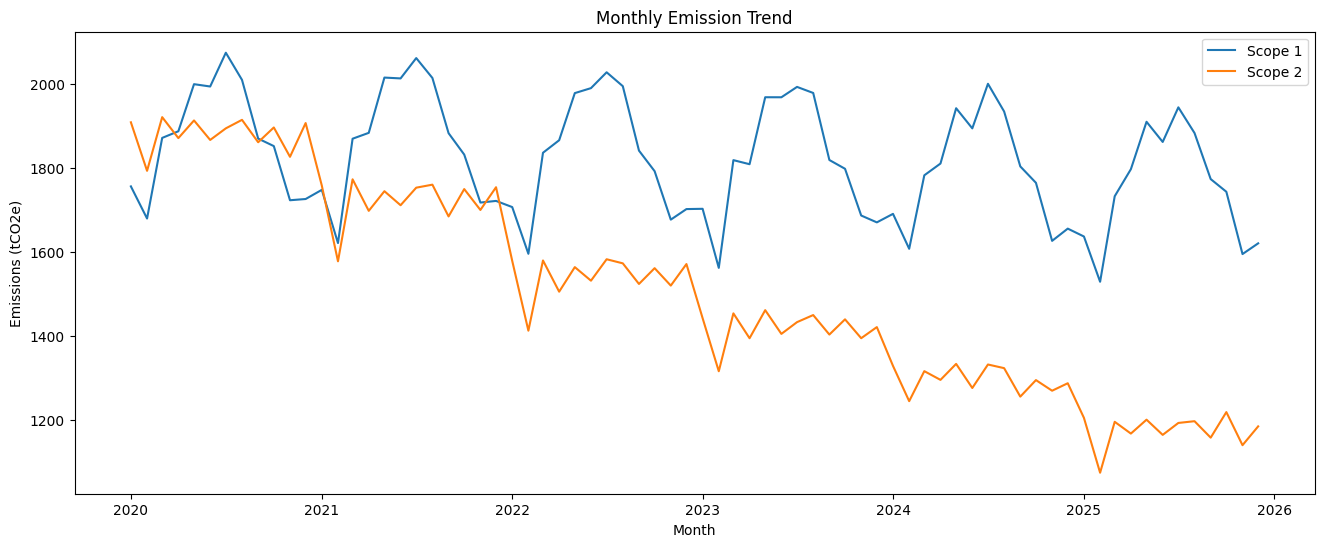

In [9]:
# Create a new column called 'month' by converting the Date column
# to monthly period format (e.g., 2024-01, 2024-02)
df['month'] = df['Date'].dt.to_period('M')


# Group data by month and Emission_Type (e.g., Scope 1, Scope 2)
# Then calculate total emissions for each group
monthly_emission = (
    df.groupby(['month', 'Emission_Type'])['Emissions_tCO2e']
      .sum()
      .reset_index()
)


# Convert month back to timestamp format for proper plotting on matplotlib
monthly_emission['month'] = monthly_emission['month'].dt.to_timestamp()


# Create figure and axis object with defined size
fig, ax = plt.subplots(figsize=[16, 6])


# Loop through emission scopes to plot each separately
for scope in ['Scope 1', 'Scope 2']:
    
    # Filter data for the specific scope
    data = monthly_emission[monthly_emission['Emission_Type'] == scope]
    
    # Plot monthly emissions trend
    ax.plot(data['month'], data['Emissions_tCO2e'], label=scope)


# Add legend to distinguish emission scopes
ax.legend()


# Add chart title and axis labels
ax.set_title('Monthly Emission Trend')
ax.set_xlabel('Month')
ax.set_ylabel('Emissions (tCO2e)')


# Display the plot
plt.show()


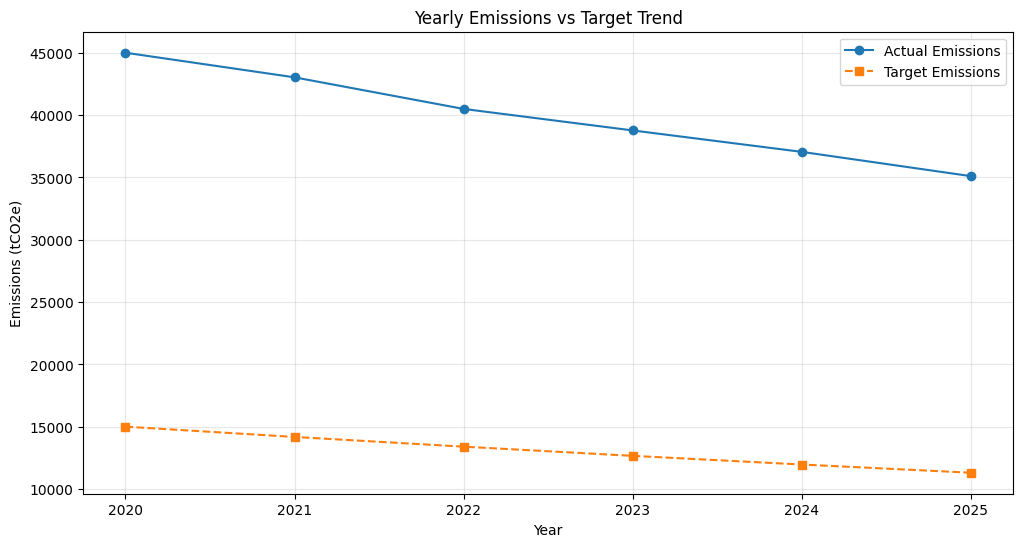

In [10]:
# Yearly emission trend 
df_year = df.groupby('Year').agg({ 
    'Emissions_tCO2e': 'sum', 
    'Target_Emissions_tCO2e': 'first' 
}).reset_index()

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot actual emissions
ax.plot(
    df_year['Year'],
    df_year['Emissions_tCO2e'],
    marker='o',
    label='Actual Emissions'
)

# Plot target emissions
ax.plot(
    df_year['Year'],
    df_year['Target_Emissions_tCO2e'],
    marker='s',
    linestyle='--',
    label='Target Emissions'
)

# Add labels and title
ax.set_title('Yearly Emissions vs Target Trend')
ax.set_xlabel('Year')
ax.set_ylabel('Emissions (tCO2e)')

# Add legend
ax.legend()

# Optional: Add grid for readability
ax.grid(True, alpha=0.3)

# Display chart
plt.show()



# Seasonal Analysis